In [14]:
using Revise
using SSMCMain, SSMCMain.MinimalModelSemisymbolic

using Base.Threads

using Symbolics
import Nemo

using JLD2
using DataFrames, FreqTables, AlgebraOfGraphics, NamedArrays, StatsBase

In [44]:
using GLMakie
using CairoMakie
CairoMakie.activate!()
# GLMakie.activate!(; px_per_unit=1.)
# display(GLMakie.Screen(), f.figure)

# Loading pscan data

In [7]:
data = jldopen("../data/minimalmodel/smallscan6.jld2");
ns_params = [data[x] for x in ["m", "l", "K", "c", "d"]];
Ds_params = [data[x] for x in ["DN", "DG", "DR"]];
ns_i_to_params = ci -> getindex.(ns_params, ci.I);
Ds_i_to_params = ci -> getindex.(Ds_params, ci.I);
num_sss = data["num_ns_steadystates"]
num_modes = data["total_num_modes"];
sss = data["ns_steadystates"];
num_modes_secs = (data["num_modes_secs"]);

In [8]:
pcis = CartesianIndices(num_sss)
Dcis =  CartesianIndices(size(num_modes)[end-2:end])
fcis =  CartesianIndices(size(num_modes))
fi_to_nsps = fci -> getindex.(ns_params, fci.I[1:5])
fi_to_Ds = fci -> getindex.(Ds_params, fci.I[6:8])
fi_to_fparams = fci -> vcat(fi_to_nsps(fci), fi_to_Ds(fci));

## Finding conditions for instabilities

#### Method 1

In [4]:
@show unique(num_modes)
fcis_unstable = findall(x->x!=0, num_modes);
length(fcis_unstable) / length(num_modes)

LoadError: UndefVarError: `num_modes` not defined

#### Method 2, build a df

In [9]:
df = DataFrame(;
    m=Float64[],
    l=Float64[],
    K=Float64[],
    c=Float64[],
    d=Float64[],
    DN=Float64[],
    DG=Float64[],
    DR=Float64[],
    num_sss=Int[],
    num_modes=Int[]
)
for fci in fcis
    nm = num_modes[fci]
    if nm != 0
        push!(df, (fi_to_fparams(fci)..., num_sss[fci.I[1:5]...], nm))
    end
end

In [30]:
mmpf = MinimalModelParamsSpace(2., 1., 2.08, 4.008, 4.008, 1e-5, 0.000398, 1e-5)

MinimalModelParamsSpace{Float64}(2.0, 1.0, 2.08, 4.008, 4.008, 1.0e-5, 0.000398, 1.0e-5)

In [28]:
df[df.m .== 2.,:]

Row,m,l,K,c,d,DN,DG,DR,num_sss,num_modes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,2.0,1.0,2.08,4.008,4.008,1.0e-5,0.000398107,1.0e-5,2,1
2,2.0,0.4,2.08,4.008,4.008,1.0e-5,0.0158489,1.0e-5,1,1
3,2.0,0.6,2.08,4.008,4.008,1.0e-5,0.0158489,1.0e-5,1,1
4,2.0,0.8,2.08,4.008,4.008,1.0e-5,0.0158489,1.0e-5,2,1
5,2.0,1.0,2.08,4.008,4.008,1.0e-5,0.0158489,1.0e-5,2,1
6,2.0,0.8,4.06,4.008,4.008,1.0e-5,0.0158489,1.0e-5,1,1
7,2.0,1.0,4.06,4.008,4.008,1.0e-5,0.0158489,1.0e-5,2,1
8,2.0,0.6,2.08,8.006,4.008,1.0e-5,0.0158489,1.0e-5,1,1
9,2.0,0.8,2.08,8.006,4.008,1.0e-5,0.0158489,1.0e-5,1,1


In [10]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,m,1.29281,0.1,1.24,2.0,0,Float64
2,l,0.65876,0.2,0.6,1.0,0,Float64
3,K,4.49253,0.1,4.06,10.0,0,Float64
4,c,11.38,4.008,12.004,20.0,0,Float64
5,d,9.33802,0.01,8.006,20.0,0,Float64
6,DN,0.0123864,1.0e-5,1.0e-5,25.1189,0,Float64
7,DG,696.187,0.000398107,1000.0,1000.0,0,Float64
8,DR,18.3641,1.0e-5,0.000398107,1000.0,0,Float64
9,num_sss,1.25201,1,1.0,2,0,Int64


In [15]:
NamedArray(cor(Matrix(df)), (names(df), names(df)))

10×10 Named Matrix{Float64}
    A ╲ B │           m            l  …      num_sss    num_modes
──────────┼──────────────────────────────────────────────────────
m         │         1.0    0.0735768  …     0.054545          NaN
l         │   0.0735768          1.0        0.714464          NaN
K         │    0.309136     0.112508     -0.00790043          NaN
c         │  -0.0412488     -0.03749      -0.0326188          NaN
d         │   0.0851701    0.0522362        0.136292          NaN
DN        │  0.00770735    0.0134154       0.0260805          NaN
DG        │  -0.0446778   -0.0619582      -0.0470419          NaN
DR        │   0.0244614     0.165836        0.228572          NaN
num_sss   │    0.054545     0.714464             1.0          NaN
num_modes │         NaN          NaN  …          NaN          1.0

#### One dim freqs

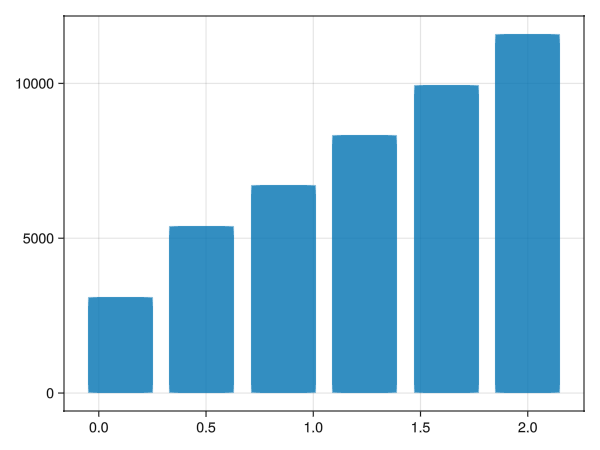

In [25]:
xx = freqtable(df, :m)
barplot(names(xx, 1), collect(xx))

#### Two dim freqs

5×5 Named Matrix{Int64}
    DN ╲ DG │ 0.000398107    0.0158489     0.630957      25.1189       1000.0
────────────┼────────────────────────────────────────────────────────────────
1.0e-5      │           2          200         1935         8395        16231
0.000398107 │           0            3          312         2716        10849
0.0158489   │           0            0            4          424         3493
0.630957    │           0            0            0            5          534
25.1189     │           0            0            0            0            6

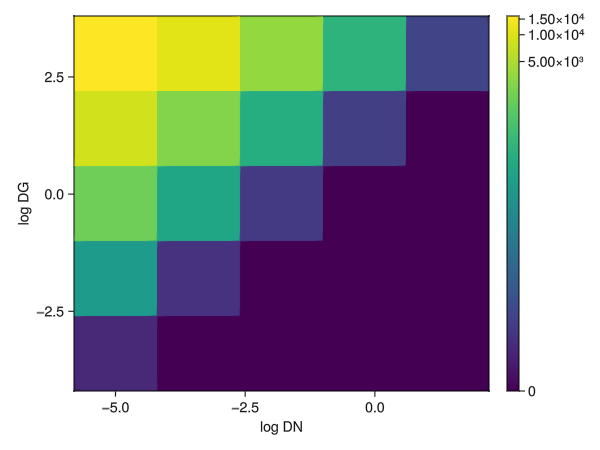

In [24]:
xx = freqtable(df, :DN, :DG)
display(xx)

xx.dimnames = Base.setindex(xx.dimnames, Symbol("log "*string(xx.dimnames[1])), 1)
setnames!(xx, log10.(names(xx, 1)), 1)
xx.dimnames = Base.setindex(xx.dimnames, Symbol("log "*string(xx.dimnames[2])), 2)
setnames!(xx, log10.(names(xx, 2)), 2)

fap = heatmap(names(xx, 1), names(xx, 2), xx; colorscale=Makie.pseudolog10)
Colorbar(fap.figure[1,2], fap.plot)

fap.axis.xlabel = string(dimnames(xx, 1))
fap.axis.ylabel = string(dimnames(xx, 2))

fap

#### Three dim freqs

In [93]:
yy = freqtable(df, :DR, :DG, :DR);

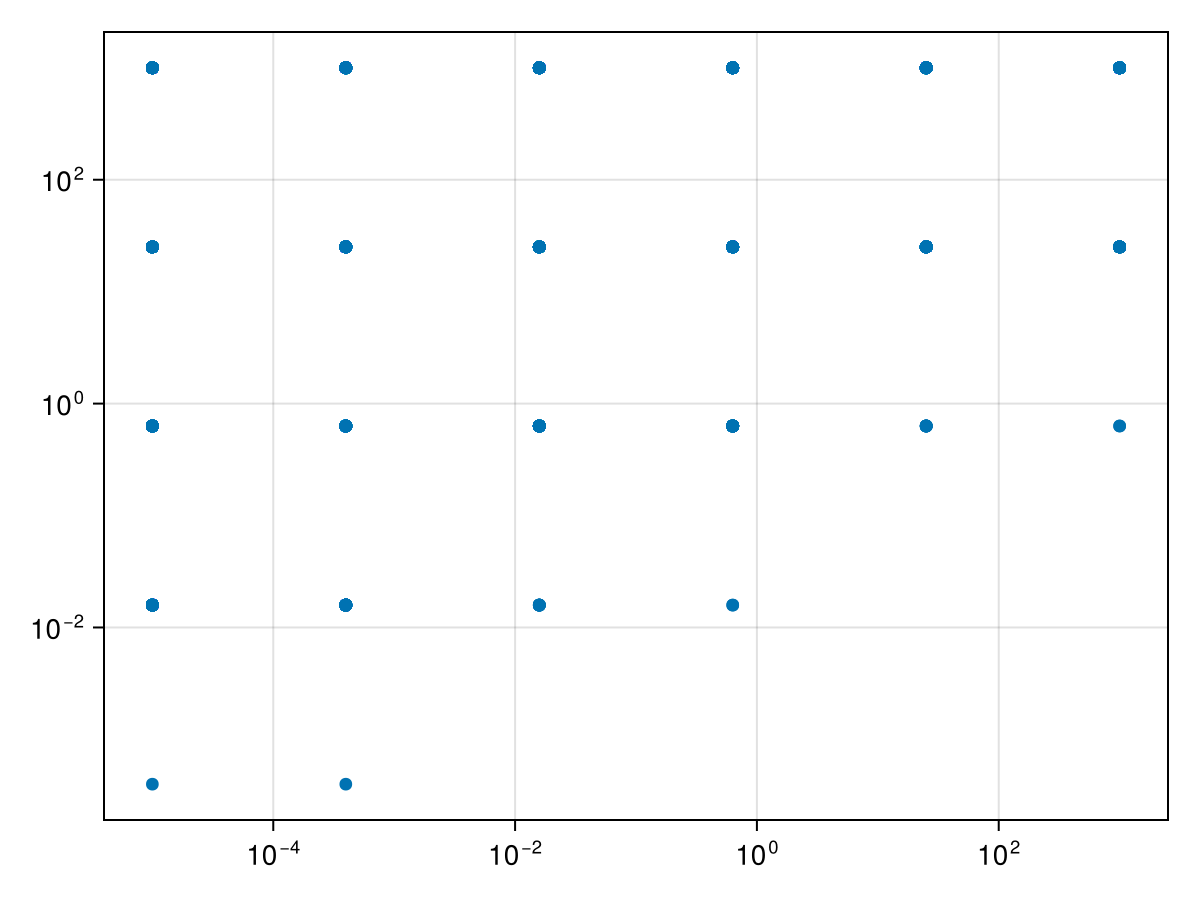

In [10]:
scatter(df.DR, df.DG; axis=(; yscale=log10, xscale=log10))

## Do we get unstable states in extinct only systems? No!

In [9]:
extinct_trh = 2*eps()
pcis_extinct_only = []
pcis_nextinct_only = []
for pci in pcis
    if num_sss[pci] == 1
        ss = sss[pci][1]
        if ss[1] < extinct_trh
            push!(pcis_extinct_only, pci)
        else
            push!(pcis_nextinct_only, pci)
        end
    end
end
display(length(pcis_extinct_only) / length(num_sss))
display(length(pcis_nextinct_only) / length(num_sss))

0.28022119341563784

0.6180555555555556

In [10]:
count(pci->maximum(num_modes[pci,:,:,:])!=0, pcis_extinct_only)

0

In [15]:
extinct_trh = 2*eps()
for pci in pcis
    for (ss_i, ss) in enumerate(sss[pci])
        if ss[1] < extinct_trh
            for Dci in Dcis
                nms = num_modes_secs[pci, Dci][ss_i]
                tnmss = sum(nms)
                @show nms
                if tnmss != 0
                    @show ss tnmss
                end
            end
        end
    end
end

nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]


Excessive output truncated after 524293 bytes.

[0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = [0]
nms = 

In [522]:
argmax(num_modes)

CartesianIndex(6, 6, 2, 2, 2, 1, 2, 1)

# Looking at a single system

In [31]:
# mmpf = MinimalModelParamsSpace(0.1, 0., 10., 0.01, 0.01, 1e-5, 0.01584893192461114, 0.00039810717055349735);
# mmpf = MinimalModelParamsSpace(fi_to_fparams(fi_to_run)...)
mmicrm_params = mmp_to_mmicrm(mmpf);
mmpf

MinimalModelParamsSpace{Float64}(2.0, 1.0, 2.08, 4.008, 4.008, 1.0e-5, 0.000398, 1.0e-5)

In [32]:
xx = analyze_single_mmps(mmpf; include_extinct=true)

(2, 1, [[0.374992839497788, 0.8310123249964403, 0.4990019960079839], [0.0, 2.08, 0.0]], [[60.15159581462648, 235.3718451500313], Float64[]], [[0, 1, 0], [0]])

## Numerics

In [33]:
all_sols = solve_nospace(mmpf)
p_sols = all_sols[nospace_sol_check_physical.(all_sols)]
display(p_sols)
nospace_sol_check_stable.(Ref(mmpf), p_sols)

3-element Vector{Vector{Float64}}:
 [0.374992839497788, 0.8310123249964403, 0.4990019960079839]
 [0.16600516449422828, 1.2489876750035596, 0.4990019960079839]
 [0.0, 2.08, 0.0]

3-element BitVector:
 1
 0
 1

In [34]:
nssol = p_sols[1]

3-element Vector{Float64}:
 0.374992839497788
 0.8310123249964403
 0.4990019960079839

#### Linstab

mrl = 0.2444572164306856


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.643883
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.643883


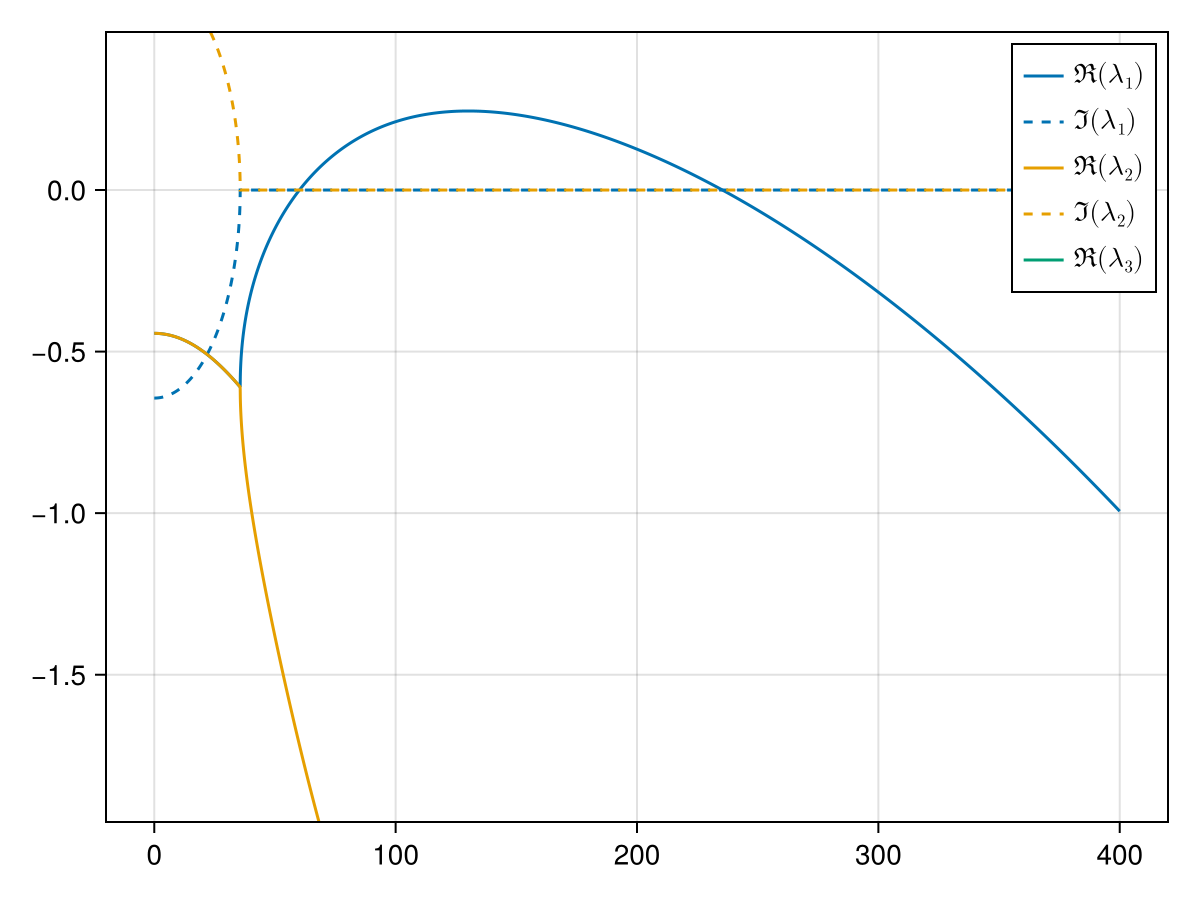

In [45]:
ks = LinRange(0., 400, 10000)
Ds = collect(get_Ds(mmpf))

lambdas = do_linstab_for_ks(ks, mmicrm_params, Ds, nssol);
mrl = maximum(real(lambdas))
@show mrl
faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (-8*mrl, 2*mrl))
# xlims!(faa.axis, (0., 2.))
#display(GLMakie.Screen(), faa.figure)
faa

In [49]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax
ff = linstab_make_full_func(mmicrm_params, nssol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
  0.9132060371498473
 -0.32073507156886566
  0.2513637753909385

### 1D PDE sim

In [50]:
ssize = (4000,)
su0 = expand_u0_to_size(ssize, nssol)
psu0 = perturb_u0_uniform(get_Ns(mmicrm_params)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.0001, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 1e6, mmicrm_params, get_Ds(mmpf), space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 4000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.0001]))

In [51]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

  7.865759 seconds (18.75 M allocations: 1.811 GiB, 8.10% gc time, 262.13% compilation time)
Success
nf is 577
solution has 136 saved states
max resid is 6.73753e-07


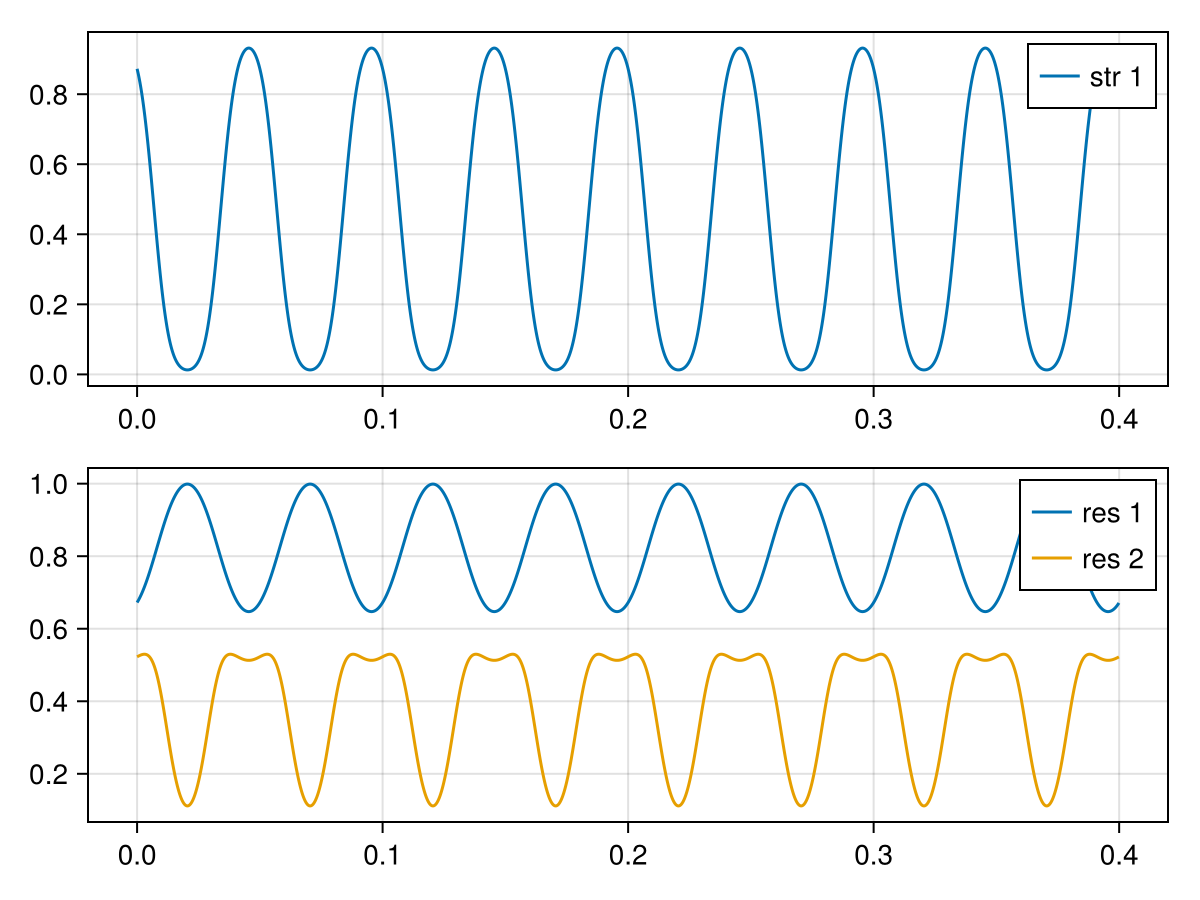

In [429]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))

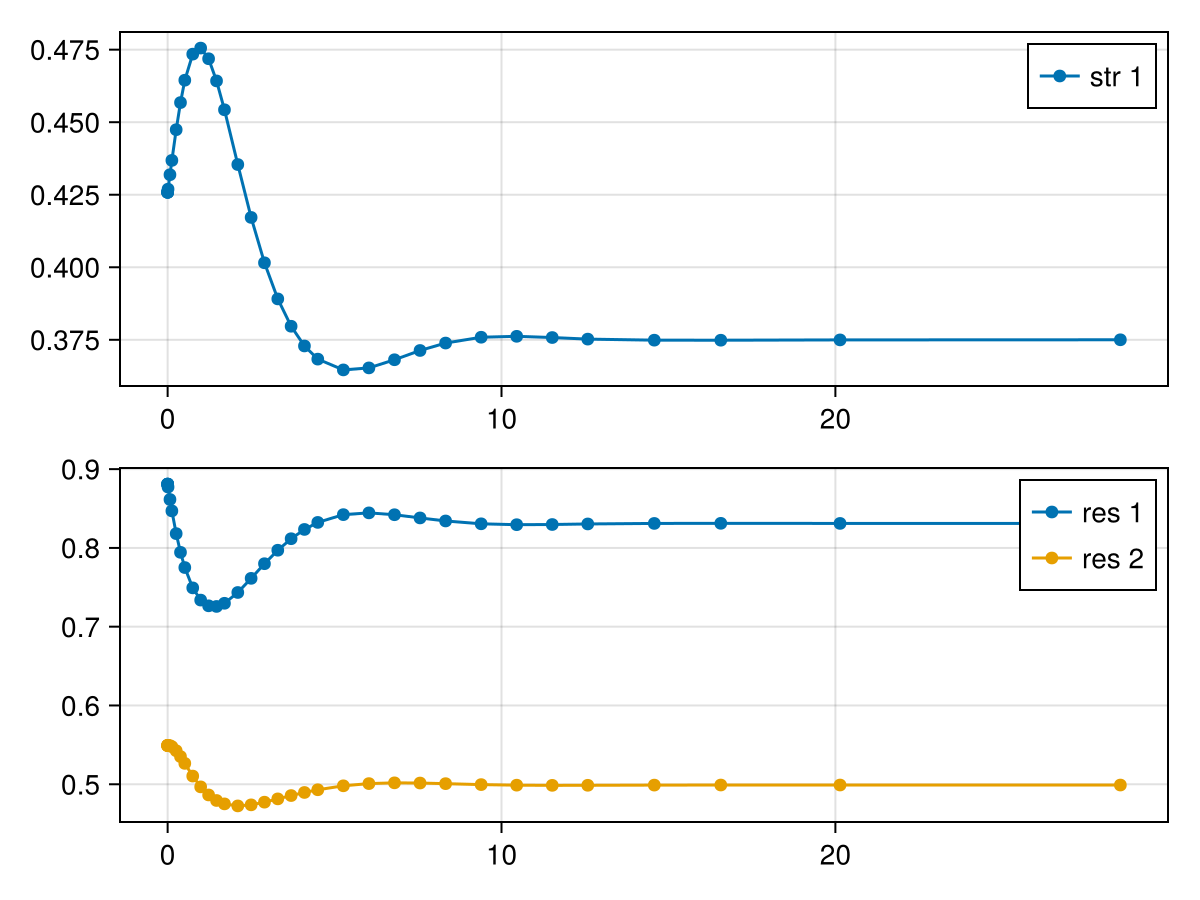

In [423]:
f = plot_smmicrm_sol_avgs(sps, 1:35)
# display(GLMakie.Screen(), f)

# Bits and bobs

### Testing

In [19]:
xx = solve_nospace(mmpf)

3-element Vector{Vector{Float64}}:
 [18.986832980505135, 0.05131670194948621, 0.05000000000000001]
 [0.013167019494861876, 1.9486832980505142, 0.04999999999999954]
 [0.0, 2.0, 0.0]

In [21]:
M1 = make_M1(mmicrm_params, xx[1])

3×3 Matrix{Float64}:
  1.38778e-17    0.0      37.9737
 -0.102633     -38.9737    0.0
  0.0026334     37.9737  -38.9737

In [33]:
pol = make_K_polynomial(M1, get_Ds(mmpf))

4-element SVector{4, Float64} with indices SOneTo(4):
   -0.0005
   -0.19490730347101168
   49.98481053361589
 -144.099930651839

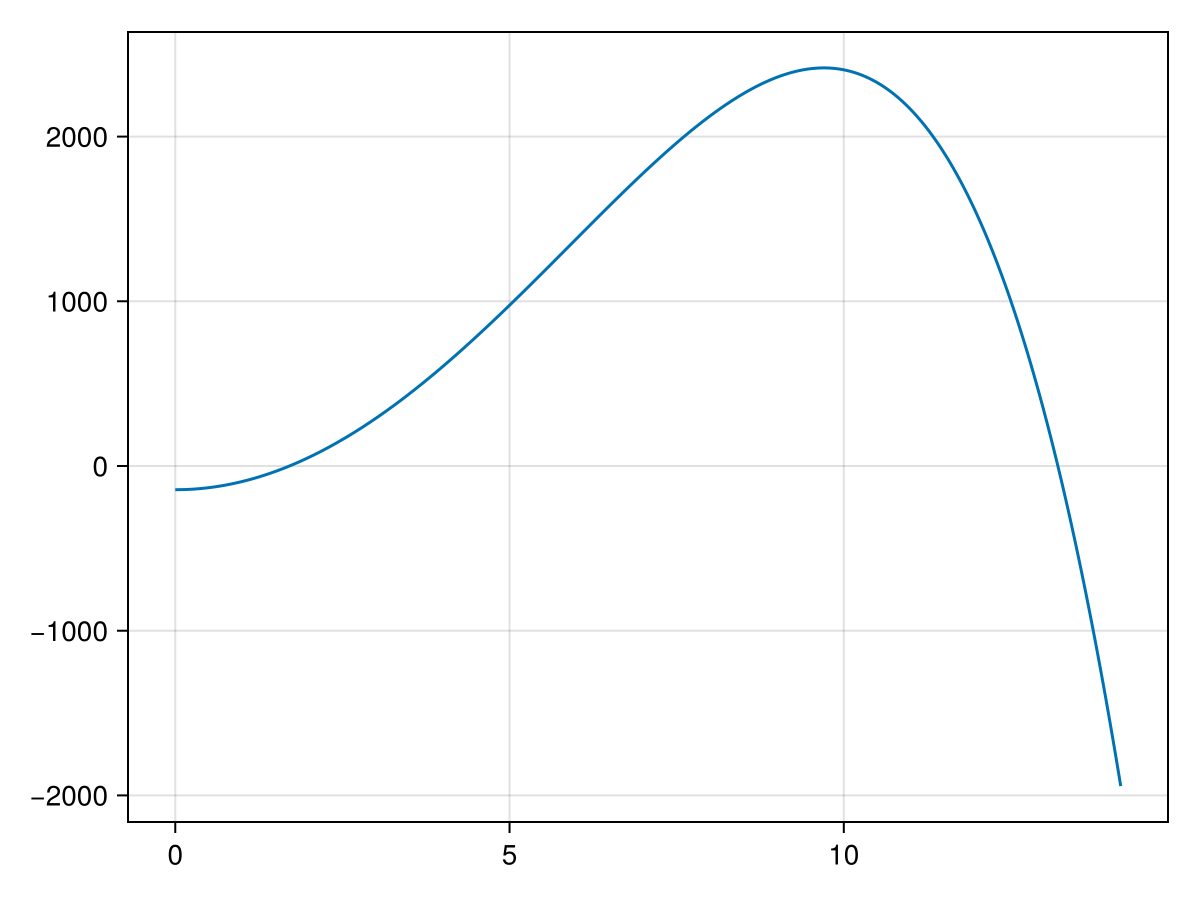

In [64]:
fks = LinRange(0, 200, 10000)
yy = eval_cubic.(Ref(pol), fks)
lines(sqrt.(fks), yy)

### Finding params so that D=0

In [45]:
@variables a b c d x p q t;
sx = t - 3*b / a
st = x + 3*b / a
display(sx)
display(st)

t + (-3b) / a

x + (3b) / a

In [47]:
ep = (3*a*c - b^2) / (3*a^2)
eq = (2*b^3 - 9*a*b*c + 27*a^2*d) / (27*a^3)
display(ep)
display(eq)

(3a*c - (b^2)) / (3(a^2))

(27(a^2)*d - 9a*b*c + 2(b^3)) / (27(a^3))

In [48]:
eD = q^2/4 + p^3/27
display(eD)

(1//4)*(q^2) + (1//27)*(p^3)

In [52]:
fD = simplify(substitute(substitute(eD, p=>ep), q=>eq))

((27//1)*(a^2)*(d^2) - (18//1)*a*b*c*d + (4//1)*a*(c^3) + (4//1)*(b^3)*d - (b^2)*(c^2)) / (108(a^4))

In [63]:
D0_sd = simplify(symbolic_solve(fD~0, d))

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 (√(-432(a^3)*(c^3) + 432(a^2)*(b^2)*(c^2) - 144a*(b^4)*c + 16(b^6)) + 18a*b*c - 4(b^3)) / (54(a^2))
 (-√(-432(a^3)*(c^3) + 432(a^2)*(b^2)*(c^2) - 144a*(b^4)*c + 16(b^6)) + 18a*b*c - 4(b^3)) / (54(a^2))

In [77]:
simplify(substitute(D0_sd[1], [a=>1,b=>1,c=>0.1]))

0.002641631005470585571790650969636567983439420046482461039933878046183213123669783